In [3]:
setwd("~/spcaFeaturesDrosophila")

In [2]:
source("_targets.R")
library(Cairo)
library(cowplot)
library(egg)
library(forcats)
library(ggnewscale)
library(ggplot2)
library(ggrastr)
library(grid)
library(gtable)
library(matrixStats)
library(reshape2)
library(scales)
library(Seurat)
library(targets)
library(tibble)
library(viridisLite)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: gridExtra


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Loading required package: ggplot2


Attaching package: ‘matrixStats’


The following object is masked from ‘package:dplyr’:

    count


Attaching SeuratObject



In [4]:
sizes <- theme(
  axis.text = element_text(size = unit(8, "pt")),
  axis.title = element_text(size = unit(10, "pt")),
  legend.text = element_text(size = unit(8, "pt")),
  legend.title = element_text(size = unit(10, "pt")),
)
theme_set(
  theme_bw() + sizes +
    theme(
      strip.background = element_rect(fill = "transparent", color = "transparent")
    )
)

In [5]:
axisline <- theme(
  axis.line = element_line(color = "grey20"),
  legend.position = "none",
  panel.grid.major.y = element_blank(),
  panel.grid.minor.y = element_blank(),
  panel.border = element_rect(color = "transparent"),
)
simple_violin_plot <- function(data, size=0.6, ...) {
  colnames(data) <- c("cluster", "embedding", "weight")
  data$cols <- "black"
  data$cols[c(1:9, 35:43)] <- "#990000"
  data <- data %>% arrange(desc(cols))
  (
    ggplot(data, aes(cluster, embedding, fill=cluster))
    + geom_violin(aes(weight=weight), linewidth=0.5, ...)
    + geom_jitter(aes(color=cols), shape=16, stroke=NA, size=size) +
    scale_color_identity()
  ) + scale_fill_hue() +
    scale_y_continuous(
      expand = c(0, 0)
    ) + labs(
      x = NULL, y = NULL
    ) + theme(
      plot.margin = margin(1, 1, 1, 1), aspect.ratio = 1
    ) +
    axisline +
    theme(
      axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5),
      strip.text = element_blank(),
    )
}

In [67]:
plotparam <- FetchData(
  indrop,
  c(
    "PC_7",
    "E(spl)mbeta-HLH",
    "LanA",
    "SPARSE_26",
    "spca_clusters",
    "lognUMI"
  )
) %>%
  with(
    tibble(
      spca_clusters,
      X = lognUMI,
      # Y = PC_7 + `E(spl)mbeta-HLH` + LanA,
      Y = SPARSE_26,
    )
  ) %>%
  subset(spca_clusters %in% c("ISC", "EB")) %>%
  group_by(spca_clusters) %>%
  summarise(
    across(
      everything(),
      list(mean=mean, sd=sd)
    ),
    R = cor(X, Y)
  ) %>%
  print(width=180)

# A tibble: 2 × 6
  spca_clusters X_mean  X_sd Y_mean  Y_sd     R
  <fct>          <dbl> <dbl>  <dbl> <dbl> <dbl>
1 ISC             7.61 0.725   3.27  1.21 0.259
2 EB              8.19 0.750   7.91  2.47 0.200


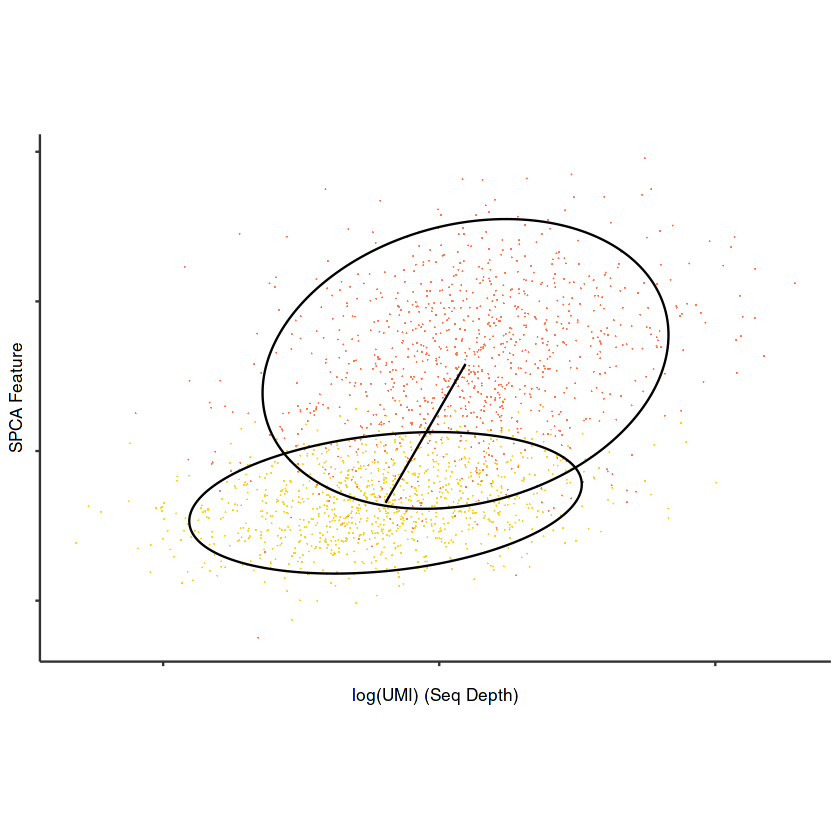

In [95]:
library(dplyr)
library(ggforce)
library(ggplot2)
library(ggrastr)
library(tibble)
library(withr)

xform <- list(
  ISC = rbind(
    c(plotparam$X_sd[1] * sqrt(1 - plotparam$R[1]^2), plotparam$X_sd[1] * plotparam$R[1], plotparam$X_mean[1]),
    c(0, plotparam$Y_sd[1], plotparam$Y_mean[1]),
    c(0, 0, 1)
  ),
  EB = rbind(
    c(plotparam$X_sd[2] * sqrt(1 - plotparam$R[2]^2), plotparam$X_sd[2] * plotparam$R[2], plotparam$X_mean[2]),
    c(0, plotparam$Y_sd[2], plotparam$Y_mean[2]),
    c(0, 0, 1)
  )
)
ellipses <- sapply(
  xform,
  \(xform) with(
    svd(xform[1:2, 1:2]),
    tibble(
      x0 = xform[1, 3],
      y0 = xform[2, 3],
      a = d[1],
      b = d[2],
      angle = atan2(u[2, 1], u[1, 1])
    )
  ),
  simplify=FALSE
) %>%
  bind_rows(.id = "celltype")

npoints <- 1000
data <- with_seed(
  0,
  sapply(
    xform,
    \(xform) rnorm(n = 2 * npoints) %>%
      matrix(nrow = 2) %>%
      rbind(rep(1, ncol(.))) %>%
      `%*%`(xform, .) %>%
      t() %>%
      as.data.frame() %>%
      subset(select=-V3) %>%
      `colnames<-`(value = c("x", "y")),
    simplify = FALSE
  ) %>%
    bind_rows(.id = "celltype") %>%
    mutate(celltype = factor(celltype, c("ISC", "EB")))
)
ggplot() +
  rasterise(
    geom_point(aes(x, y, color=celltype), data, stroke=NA, size=0.5),
    dpi=600
  ) +
  scale_color_manual(
    values = c("#FAD11B", "#FF7349")
  ) +
  geom_ellipse(
    aes(x0 = x0, y0 = y0, a = a * qnorm(0.975), b = b * qnorm(0.975), angle = angle),
    ellipses,
    color = "black"
  ) +
  annotate(
    "segment",
    ellipses$x0[1],
    ellipses$y0[1],
    xend = ellipses$x0[2],
    yend = ellipses$y0[2]
  ) +
  scale_x_continuous(breaks = scales::pretty_breaks(3), labels = \(x) rep("", length(x))) +
  scale_y_continuous(labels = \(x) rep("", length(x))) +
  labs(x = "log(UMI) (Seq Depth)", y = "SPCA Feature") +
  axisline +
  theme(
    aspect.ratio = 2/3,
    legend.position = "none",
    panel.grid = element_blank(),
  )
ggsave("figure/Fig4Ill.pdf", w=2.5, h=1.75)

In [100]:
blt <- ggplot_build(last_plot())

In [101]:
round(c(4.5, 2) / (diff(ellipses$y0) / diff(ellipses$x0) * 1.2588 / 1.8851 / (diff(blt$layout$panel_params[[1]]$y$limits) / diff(blt$layout$panel_params[[1]]$x$limits))), 4)

[1] 2.5875 1.1500

In [6]:
tar_load(c(indrop, indrop.sct, indrop.sct.pca))

In [7]:
table(indrop$sct_subclassif)


        ISC          EB         dEC         aEC     EC-like         mEC 
        370         103         745        1589        2203         120 
        pEC          EE copper/iron         LFC      cardia      others 
        610         572         380         143         194         479 
                cardia. 
         89          29 

In [8]:
cor(indrop$lognUMI, log(indrop$nCount_RNA))

[1] 0.9999999

In [9]:
pcs <- tibble(
  reduction = c("LN PCA", "SCT PCA", "LN SPCA") %>% factor(., .),
  obj = list(indrop[["pca"]], indrop.sct.pca, indrop[["spca"]]),
  feature = list(indrop$pca_subclassif, indrop$sct_subclassif, indrop$spca_subclassif)
) %>%
  group_by(reduction) %>%
  summarise(
    dim = 1:34,
    total = obj[[1]]@stdev[dim]^2,
    logUMI = as.numeric(cor(obj[[1]]@cell.embeddings[, dim], indrop$lognUMI))^2 * total,
    pctMito = as.numeric(cor(obj[[1]]@cell.embeddings[, dim], indrop$pctMito))^2 * total,
    pctRibo = as.numeric(cor(obj[[1]]@cell.embeddings[, dim], indrop$pctRibo))^2 * total,
    explained = apply(
      obj[[1]]@cell.embeddings[, dim],
      2,
      \(v) summary(lm(v ~ feature[[1]]))$r.squared
    ) *
      total,
  ) %>%
  print()

`summarise()` has grouped output by 'reduction'. You can override using the
`.groups` argument.


# A tibble: 102 × 7
# Groups:   reduction [3]
   reduction   dim total  logUMI pctMito  pctRibo explained
   <fct>     <int> <dbl>   <dbl>   <dbl>    <dbl>     <dbl>
 1 LN PCA        1 37.6  2.26    0.782   0.0422      20.1  
 2 LN PCA        2 26.3  4.98    0.368   0.203       13.9  
 3 LN PCA        3 22.8  2.77    1.06    0.139       16.5  
 4 LN PCA        4 15.8  2.57    1.44    0.000698    10.2  
 5 LN PCA        5 13.9  0.193   0.00160 0.709       10.8  
 6 LN PCA        6 11.8  0.671   0.673   0.147        8.33 
 7 LN PCA        7 11.1  1.41    0.137   1.73         8.72 
 8 LN PCA        8  9.72 0.360   0.00798 0.0449       5.98 
 9 LN PCA        9  8.08 0.00384 0.0474  0.0757       1.50 
10 LN PCA       10  7.53 0.0236  0.299   0.0194       0.893
# … with 92 more rows


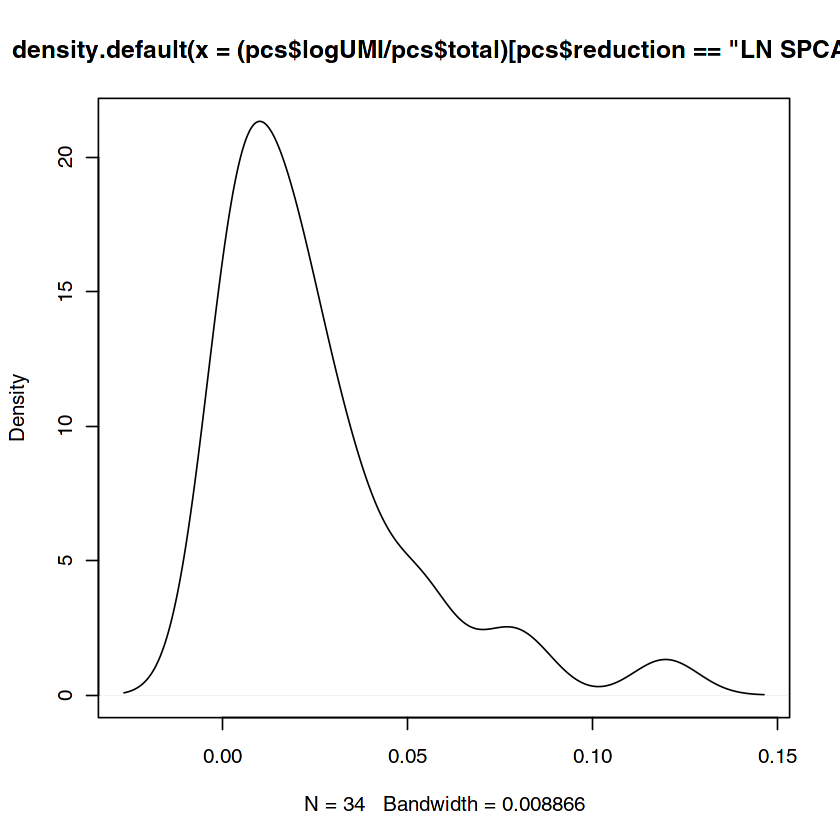

In [10]:
plot(density((pcs$logUMI / pcs$total)[pcs$reduction == "LN SPCA"]))

Warning message:
“The following aesthetics were dropped during statistical transformation: weight
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?”


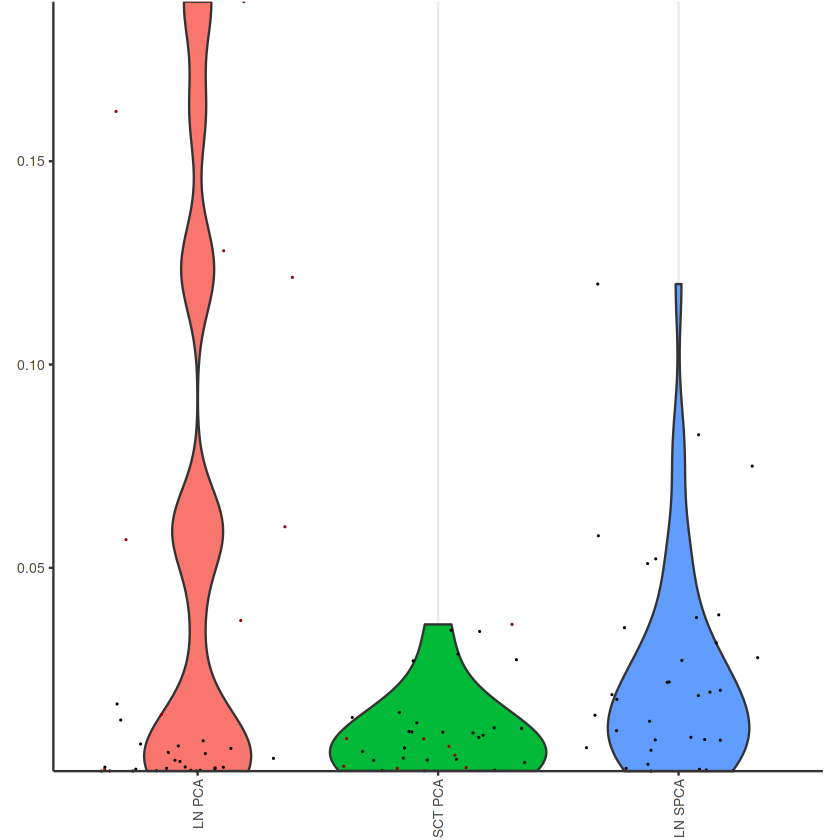

In [11]:
simple_violin_plot(with(pcs, tibble(reduction, logUMI/total, total)), bw=0.01)

Warning message:
“The following aesthetics were dropped during statistical transformation: weight
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?”


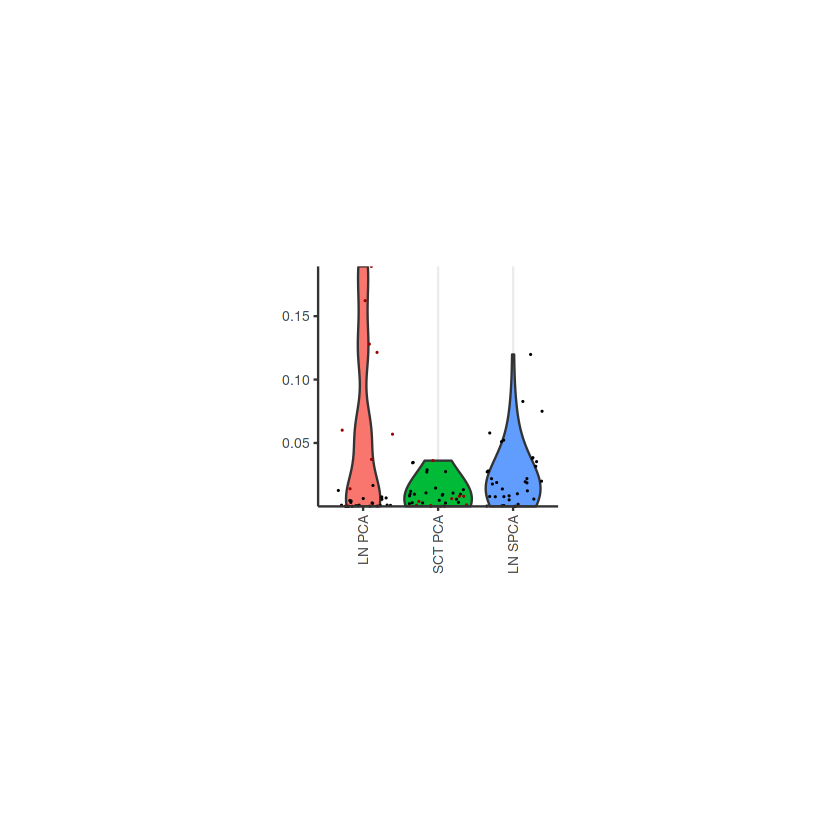

In [12]:
simple_violin_plot(with(pcs, tibble(reduction, logUMI/total, total)), bw=0.02) %>%
  set_panel_size(w = unit(2, "in"), h = unit(2, "in")) %>%
  grid.draw()

Warning message:
“The following aesthetics were dropped during statistical transformation: weight
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?”


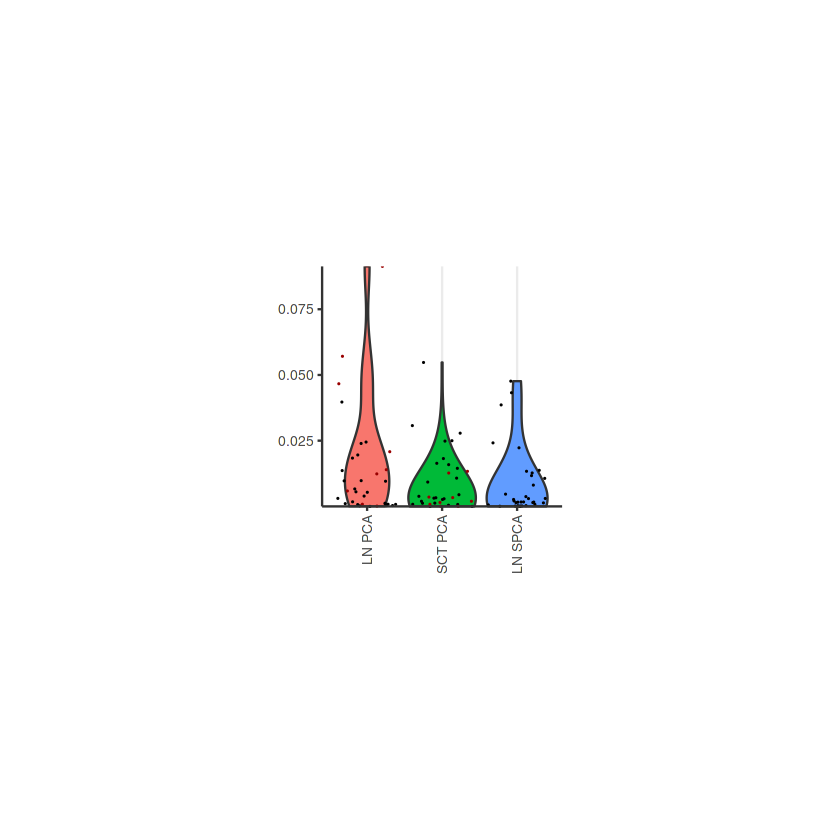

In [13]:
simple_violin_plot(with(pcs, tibble(reduction, pctMito/total, total)), bw=0.01) %>%
  set_panel_size(w = unit(2, "in"), h = unit(2, "in")) %>%
  grid.draw()

Warning message:
“The following aesthetics were dropped during statistical transformation: weight
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?”


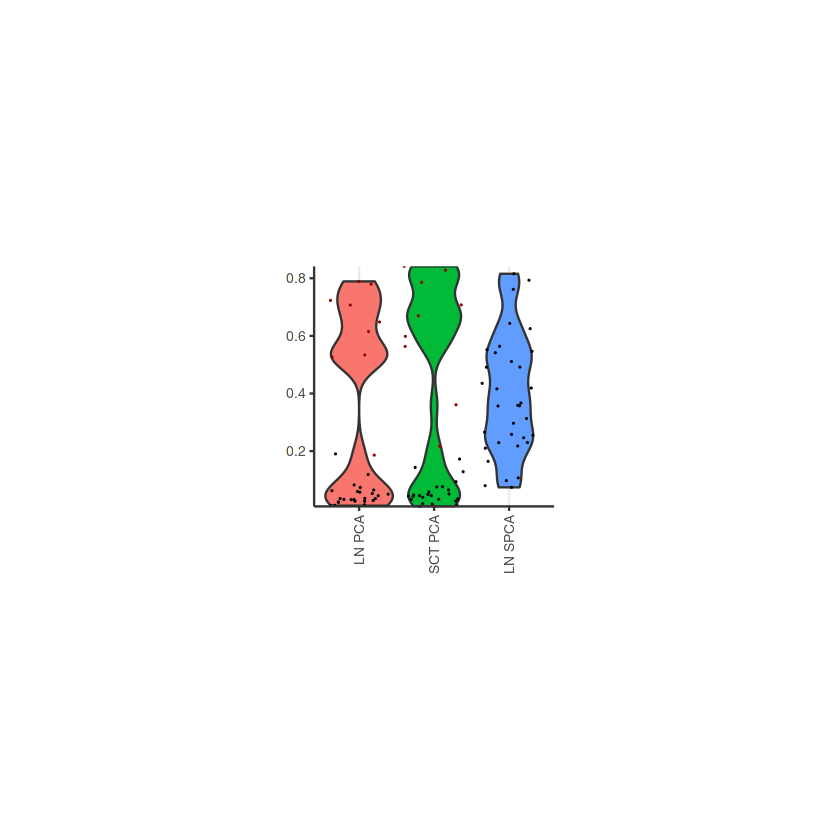

In [14]:
simple_violin_plot(with(pcs, tibble(reduction, explained/total, total)), bw=0.05) %>%
  set_panel_size(w = unit(2, "in"), h = unit(2, "in")) %>%
  grid.draw()

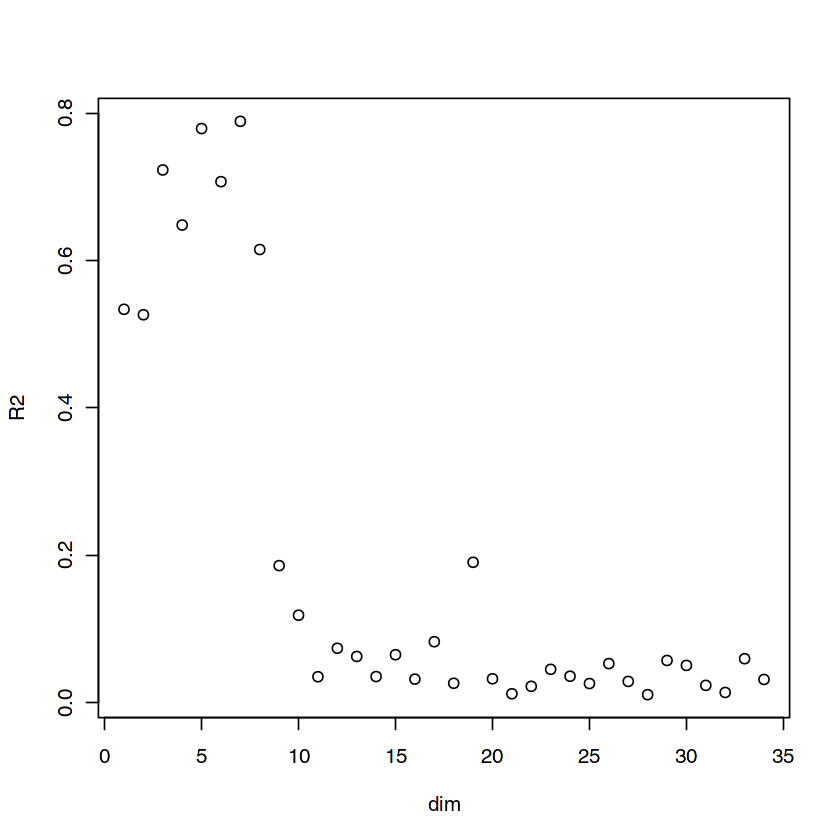

In [15]:
plot(
  subset(
    tibble(pcs, R2 = explained/total),
    reduction == "LN PCA",
    select = c(dim, R2)
  )
)

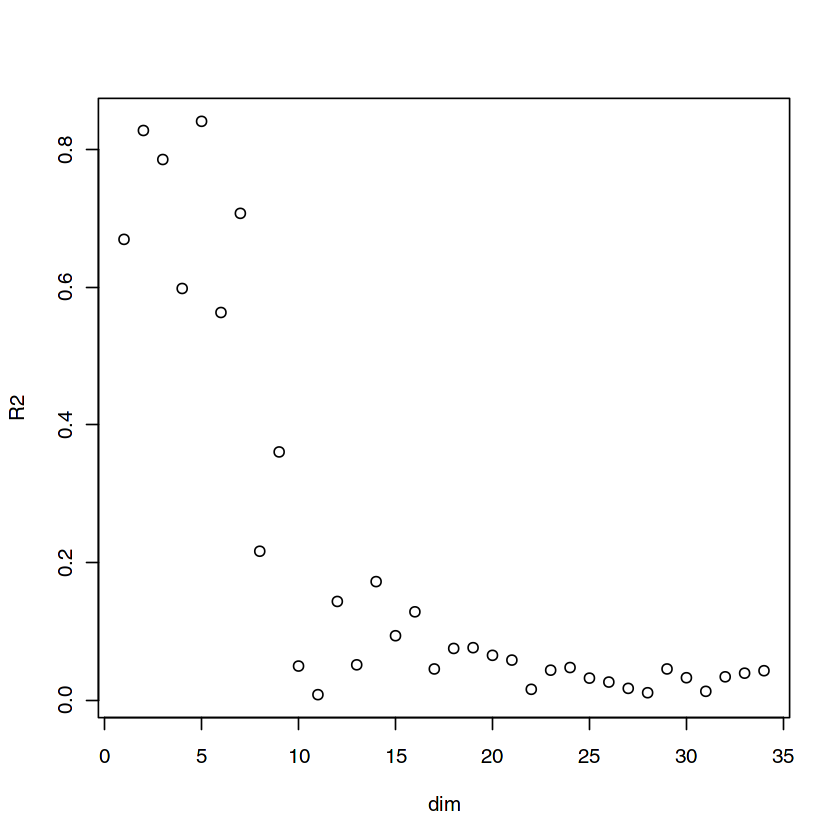

In [16]:
plot(
  subset(
    tibble(pcs, R2 = explained/total),
    reduction == "SCT PCA",
    select = c(dim, R2)
  )
)

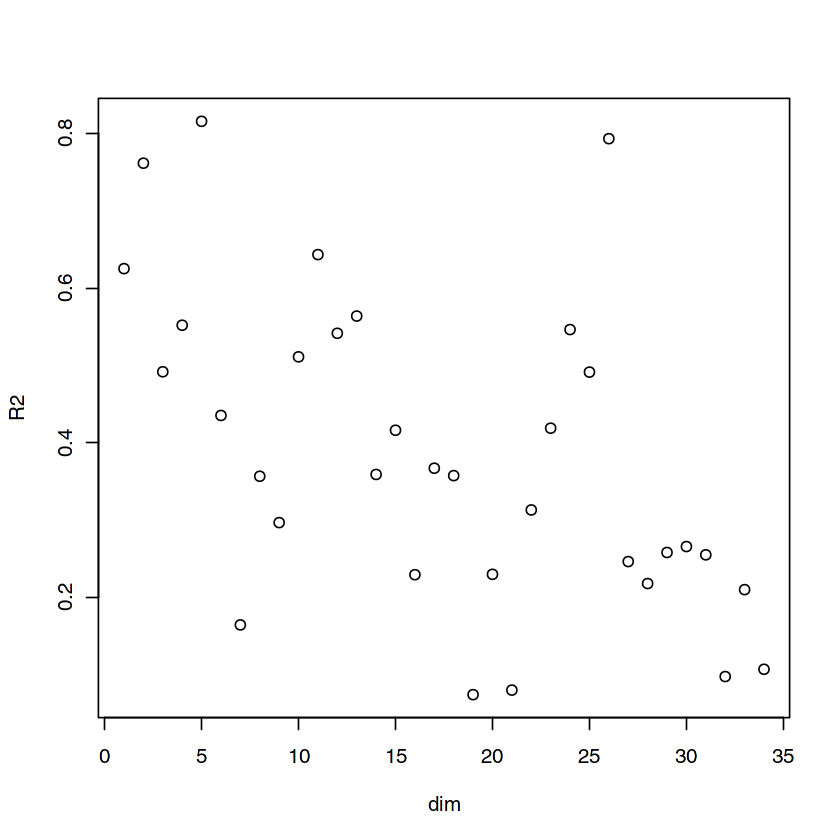

In [17]:
plot(
  subset(
    tibble(pcs, R2 = explained/total),
    reduction == "LN SPCA",
    select = c(dim, R2)
  )
)

In [18]:
dim(indrop.sct@scale.data[rownames(indrop.sct.pca@feature.loadings), ])

[1] 3000 7626

In [19]:
length(rowSums(indrop.sct.pca@cell.embeddings[, 1:9]^2))

[1] 7626

In [20]:
models <- tibble(
  reduction = c("LN PCA", "SCT PCA", "LN SPCA") %>% factor(., .),
  data = list(
    indrop[["pca"]]@cell.embeddings[, 1:9],
    indrop.sct.pca@cell.embeddings[, 1:9],
    indrop[["spca"]]@cell.embeddings[, 1:34]
  ),
  unitVar = c(
    1,
    rep(
      rowVars(indrop.sct@scale.data[rownames(indrop.sct.pca@feature.loadings), ]),
      1e5 * (
        rowSums(indrop.sct.pca@feature.loadings[, 1:9]^2) %>%
          `/`(sum(.)) %>%
          round(5)
      )
    ) %>%
      median(),
    1
  ),
  feature = list(
    indrop$pca_subclassif,
    indrop$sct_subclassif,
    indrop$spca_subclassif
  )
) %>%
  print()

# A tibble: 3 × 4
  reduction data               unitVar feature      
  <fct>     <list>               <dbl> <list>       
1 LN PCA    <dbl [7,626 × 9]>     1    <fct [7,626]>
2 SCT PCA   <dbl [7,626 × 9]>     5.16 <fct [7,626]>
3 LN SPCA   <dbl [7,626 × 34]>    1    <fct [7,626]>


In [21]:
x <- models$feature[[3]] %>%
  subset(
    models$feature[[3]] %in%
      c("EC-like", "aEC", "mEC", "pEC", "ISC", "EB", "EE")
  ) %>%
  fct_recode(
    EC="EC-like", EC="aEC", EC="mEC", EC="pEC",
    `stem cell`="ISC", `stem cell`="EB"
  ) %>%
  fct_relevel(c("stem cell", "EC", "EE"))
table(x)
Y <- models$data[[3]] %>%
  subset(
    models$feature[[3]] %in%
      c("EC-like", "aEC", "mEC", "pEC", "ISC", "EB", "EE")
  )
dim(Y)

x
  stem cell          EC          EE         dEC copper/iron         LFC 
        540        4825         555           0           0           0 
     cardia      others 
          0           0 

[1] 5920   34

In [22]:
model <- manova(Y ~ lognUMI, list(lognUMI = subset(indrop$lognUMI, models$feature[[3]] %in%
      c("EC-like", "aEC", "mEC", "pEC", "ISC", "EB", "EE")
)), subset = x == "stem cell") %>%
  print()

Call:
   manova(Y ~ lognUMI, list(lognUMI = subset(indrop$lognUMI, models$feature[[3]] %in% 
    c("EC-like", "aEC", "mEC", "pEC", "ISC", "EB", "EE"))), subset = x == 
    "stem cell")

Terms:
                 lognUMI Residuals
SPARSE_1           1.835   222.569
SPARSE_2           0.063    66.263
SPARSE_3           0.067    98.198
SPARSE_4           0.091    57.358
SPARSE_5           0.408    25.525
SPARSE_6           0.422    88.987
SPARSE_7           0.274    58.034
SPARSE_8           0.001    29.050
SPARSE_9           0.014    18.079
SPARSE_10          1.182    99.913
SPARSE_11          0.400    52.223
SPARSE_12          0.058    54.371
SPARSE_13          0.382    25.349
SPARSE_14          0.059    73.906
SPARSE_15          0.153    36.906
SPARSE_16          0.000    94.177
SPARSE_17          0.308    55.552
SPARSE_18          0.019   107.703
SPARSE_19          1.768   146.211
SPARSE_20          0.000    31.627
SPARSE_21          0.137    47.528
SPARSE_22          1.731   157.714
SP

In [23]:
sum(colVars(model$fitted.values))

[1] 1.607289

In [24]:
sum(colVars(model$residuals))

[1] 12.72246

In [25]:
model <- manova(Y ~ lognUMI * x, list(lognUMI = subset(indrop$lognUMI, models$feature[[3]] %in%
      c("EC-like", "aEC", "mEC", "pEC", "ISC", "EB", "EE")
))) %>%
  print()

Call:
   manova(Y ~ lognUMI * x, list(lognUMI = subset(indrop$lognUMI, 
    models$feature[[3]] %in% c("EC-like", "aEC", "mEC", "pEC", 
        "ISC", "EB", "EE"))))

Terms:
                  lognUMI         x lognUMI:x Residuals
SPARSE_1          893.671 12424.709     2.536 24874.744
SPARSE_2          736.975   176.511    44.245  5571.306
SPARSE_3          345.529  8905.540   163.561 21742.010
SPARSE_4         1007.913   761.341    76.784 11103.595
SPARSE_5          755.657   787.378    97.303 29644.382
SPARSE_6           28.876    11.752     3.748  2740.414
SPARSE_7          178.517   872.203     6.454 28231.919
SPARSE_8         1147.279  3941.999   215.243 20725.353
SPARSE_9          352.134  1527.551    74.223 25089.056
SPARSE_10          25.382    15.250    11.169  2306.861
SPARSE_11         801.243   724.086    58.962 16843.835
SPARSE_12          78.233  2391.911    31.897 15569.561
SPARSE_13           6.086 14282.691   648.575 10112.276
SPARSE_14          37.370    38.530     3.

In [26]:
sum(colVars(subset(model$fitted.values, x == "stem cell")))

[1] 1.607289

In [27]:
sum(colVars(subset(model$residuals, x == "stem cell")))

[1] 12.72246

In [28]:
model <- manova(Y ~ s, list(s = seq_along(x)), subset = x == "stem cell") %>%
  print()

Call:
   manova(Y ~ s, list(s = seq_along(x)), subset = x == "stem cell")

Terms:
                       s Residuals
SPARSE_1          19.954   204.450
SPARSE_2           1.053    65.272
SPARSE_3           1.063    97.202
SPARSE_4           0.543    56.906
SPARSE_5           0.013    25.919
SPARSE_6           0.993    88.416
SPARSE_7           0.806    57.502
SPARSE_8            0.25     28.80
SPARSE_9           0.004    18.089
SPARSE_10          0.289   100.807
SPARSE_11          0.390    52.234
SPARSE_12          2.419    52.011
SPARSE_13          0.471    25.260
SPARSE_14          0.041    73.923
SPARSE_15          2.078    34.981
SPARSE_16          0.034    94.143
SPARSE_17          1.767    54.092
SPARSE_18          2.636   105.086
SPARSE_19          1.731   146.248
SPARSE_20          0.318    31.309
SPARSE_21          0.170    47.494
SPARSE_22          0.392   159.054
SPARSE_23          0.041    33.266
SPARSE_24         10.448   350.236
SPARSE_25          0.933   103.246
SPARSE_2

In [29]:
sum(colVars(model$fitted.values))

[1] 0.1356061

In [30]:
print(models)

# A tibble: 3 × 4
  reduction data               unitVar feature      
  <fct>     <list>               <dbl> <list>       
1 LN PCA    <dbl [7,626 × 9]>     1    <fct [7,626]>
2 SCT PCA   <dbl [7,626 × 9]>     5.16 <fct [7,626]>
3 LN SPCA   <dbl [7,626 × 34]>    1    <fct [7,626]>


In [31]:
groupwise_models <- models %>%
  rowwise() %>%
  summarise(
    reduction,
    celltype = c("stem cell", "EC", "EE") %>% factor(., .),
    unitVar,
    data = list(data),
    logUMI = list(indrop$lognUMI),
    pctMito = list(indrop$pctMito),
    pctRibo = list(indrop$pctRibo),
    feature = feature %>%
      fct_recode(
        EC="EC-like", EC="aEC", EC="mEC", EC="pEC",
        `stem cell`="ISC", `stem cell`="EB"
      ) %>%
      list(),
  ) %>%
  rowwise() %>%
  summarise(
    reduction,
    celltype,
    unitVar,
    total_var = sum(colVars(subset(data, feature == as.character(celltype)))) / unitVar,
    across(
      c(logUMI, pctMito, pctRibo),
      list(
        var = \(regressor) sum(
          colVars(
            manova(
              data ~ regressor,
              subset = feature == as.character(celltype)
            )$fitted.values
          )
        ) /
          unitVar
      )
    )
  ) %>%
  print()

# A tibble: 9 × 7
  reduction celltype  unitVar total_var logUMI_var pctMito_var pctRibo_var
  <fct>     <fct>       <dbl>     <dbl>      <dbl>       <dbl>       <dbl>
1 LN PCA    stem cell    1        27.0      12.8         6.96        5.21 
2 LN PCA    EC           1        96.9      19.7         6.71        1.72 
3 LN PCA    EE           1        43.1      19.4         4.98        0.250
4 SCT PCA   stem cell    5.16      3.06      0.624       0.406       0.293
5 SCT PCA   EC           5.16     78.7       7.72        2.22        1.86 
6 SCT PCA   EE           5.16     30.7       9.94        7.31        1.43 
7 LN SPCA   stem cell    1        14.3       1.61        0.935       1.27 
8 LN SPCA   EC           1        87.4       4.75        1.75        1.13 
9 LN SPCA   EE           1        43.2       2.49        1.04        0.964


In [32]:
print(models$reduction)

[1] LN PCA  SCT PCA LN SPCA
Levels: LN PCA SCT PCA LN SPCA


In [33]:
ssb_models <- models %>%
  rowwise() %>%
  summarise(
    reduction,
    celltype = c("stem cell", "EC", "EE") %>% factor(., .) %>% head(1),
    unitVar,
    data = list(data),
    logUMI = list(indrop$lognUMI),
    pctMito = list(indrop$pctMito),
    pctRibo = list(indrop$pctRibo),
    feature.orig = list(feature),
    feature = feature %>%
      fct_recode(
        EC="EC-like", EC="aEC", EC="mEC", EC="pEC",
        `stem cell`="ISC", `stem cell`="EB"
      ) %>%
      list(),
  ) %>%
  rowwise() %>%
  summarise(
    reduction,
    celltype,
    unitVar,
    total_var = sum(colVars(subset(data, feature == as.character(celltype)))) / unitVar,
    across(
      c(logUMI, pctMito, pctRibo),
      list(
        var = \(regressor) sum(
          colVars(
            manova(
              data.between ~ regressor,
              list(
                data.between = manova(
                  data ~ feature.orig
                )$fitted.values
              ),
              subset = feature == as.character(celltype)
            )$fitted.values
          )
        ) /
          unitVar
      )
    )
  ) %>%
  print()

# A tibble: 3 × 7
  reduction celltype  unitVar total_var logUMI_var pctMito_var pctRibo_var
  <fct>     <fct>       <dbl>     <dbl>      <dbl>       <dbl>       <dbl>
1 LN PCA    stem cell    1        27.0       6.23        2.93        2.68 
2 SCT PCA   stem cell    5.16      3.06      0.232       0.155       0.116
3 LN SPCA   stem cell    1        14.3       0.728       0.511       0.392


In [34]:
stemcell_models <- models %>%
  rowwise() %>%
  summarise(
    reduction,
    celltype = c("ISC", "EB") %>% factor(., .),
    unitVar,
    data = list(data),
    logUMI = list(indrop$lognUMI),
    pctMito = list(indrop$pctMito),
    pctRibo = list(indrop$pctRibo),
    feature = list(feature),
  ) %>%
  rowwise() %>%
  summarise(
    reduction,
    celltype,
    unitVar,
    total_var = sum(colVars(subset(data, feature == as.character(celltype)))) / unitVar,
    across(
      c(logUMI, pctMito, pctRibo),
      list(
        var = \(regressor) sum(
          colVars(
            manova(
              data ~ regressor,
              subset = feature == as.character(celltype)
            )$fitted.values
          )
        ) /
          unitVar
      )
    )
  ) %>%
  print()

# A tibble: 6 × 7
  reduction celltype unitVar total_var logUMI_var pctMito_var pctRibo_var
  <fct>     <fct>      <dbl>     <dbl>      <dbl>       <dbl>       <dbl>
1 LN PCA    ISC         1         7.62     1.52        0.272       0.387 
2 LN PCA    EB          1        18.1      3.02        2.92        1.02  
3 SCT PCA   ISC         5.16      1.98     0.166       0.0811      0.0679
4 SCT PCA   EB          5.16      1.20     0.0681      0.0751      0.0500
5 LN SPCA   ISC         1         5.25     0.205       0.0401      0.0768
6 LN SPCA   EB          1        13.0      0.378       0.245       0.867 


In [35]:
summarise(rbind(ssb_models, stemcell_models), reduction, celltype, logUMI_var, pctMito_var) %>% arrange(reduction)

reduction,celltype,logUMI_var,pctMito_var
<fct>,<fct>,<dbl>,<dbl>
LN PCA,stem cell,6.23264175,2.92761949
LN PCA,ISC,1.52227237,0.27187973
LN PCA,EB,3.01851451,2.92045092
SCT PCA,stem cell,0.23242634,0.15456007
SCT PCA,ISC,0.16648162,0.08110283
SCT PCA,EB,0.06808261,0.07514738
LN SPCA,stem cell,0.72824122,0.51120526
LN SPCA,ISC,0.20475147,0.04006343
LN SPCA,EB,0.37764664,0.24511505


In [36]:
summarise(rbind(ssb_models, stemcell_models), reduction, celltype, R2_logUMI = logUMI_var / total_var, R2_pctMito = pctMito_var / total_var) %>% arrange(reduction)

reduction,celltype,R2_logUMI,R2_pctMito
<fct>,<fct>,<dbl>,<dbl>
LN PCA,stem cell,0.23052647,0.108283742
LN PCA,ISC,0.19975157,0.035675877
LN PCA,EB,0.16708514,0.161656988
SCT PCA,stem cell,0.07605420,0.050574912
SCT PCA,ISC,0.08426727,0.041051465
SCT PCA,EB,0.05662334,0.062499008
LN SPCA,stem cell,0.05082025,0.035674417
LN SPCA,ISC,0.03899358,0.007629819
LN SPCA,EB,0.02899609,0.018820182


In [37]:
theme_bw()$panel.grid

List of 6
 $ colour       : chr "grey92"
 $ linewidth    : NULL
 $ linetype     : NULL
 $ lineend      : NULL
 $ arrow        : logi FALSE
 $ inherit.blank: logi TRUE
 - attr(*, "class")= chr [1:2] "element_line" "element"

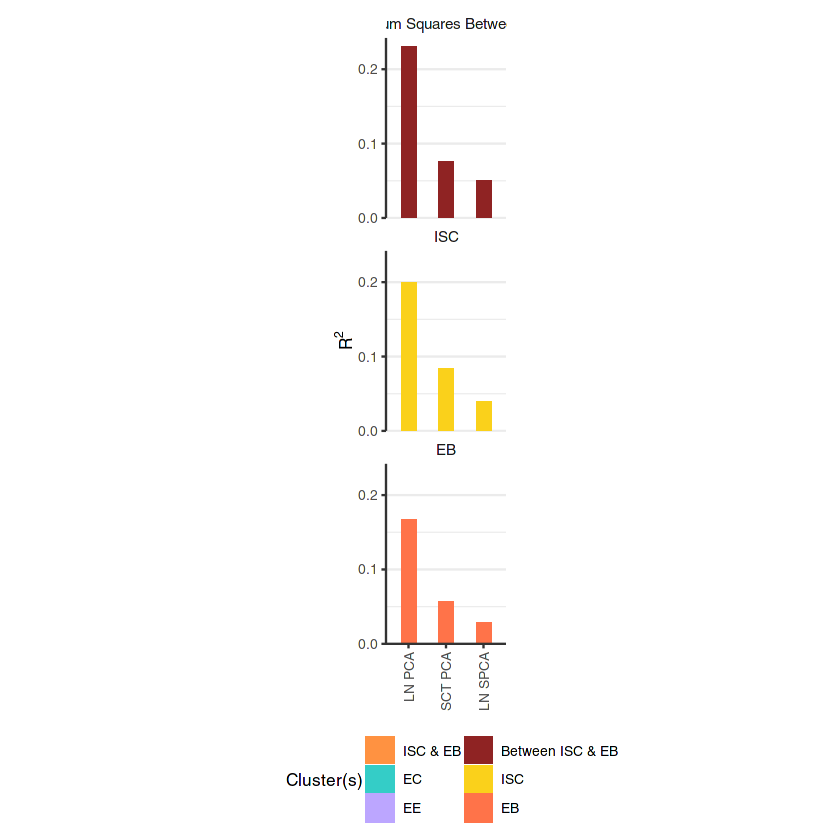

In [38]:
between_color <- "#8f2323"
report_violin <- simple_violin_plot(with(pcs, tibble(reduction, logUMI/total, total)), bw=0.02, size=1.5) +
  coord_cartesian(clip = "off") +
  theme(legend.position = "off") +
  labs(y = bquote(R^2))
report_bars <- ggplot(
  tibble(
    full_join(
      groupwise_models,
      tibble(facet = c("Seq Depth", "Total") %>% factor(., .)),
      by = character(0)
    ),
    var = cbind(
      Numer = logUMI_var,
      Total = total_var
    )[
      cbind(
        seq_along(facet),
        as.numeric(facet)
      )
    ]
  ),
  aes(reduction, var, fill=celltype)
) +
  facet_wrap(vars(facet), scales = "free_x") +
  scale_fill_manual(
    values = midgut.col %>% setNames(names(.) %>% replace(3, "stem cell"))
  ) +
  coord_flip() +
  scale_x_discrete(limits = rev) +
  scale_y_continuous(breaks = pretty_breaks(n = 2), limits = \(rng) c(0, 1.05 * max(rng)), expand = c(0, 0)) +
  geom_bar(data = \(data) data %>% mutate(celltype = celltype %>% factor(rev(levels(.)))), stat = "identity", position = "dodge") +
  labs(x = NULL, y = "Explained Variance") +
  axisline
R2_bars <- ggplot(
  mutate(rbind(ssb_models, stemcell_models), R2 = logUMI_var / total_var),
  aes(reduction, R2)
) +
  facet_wrap(
    ~factor(celltype, c("stem cell", "ISC", "EB")),
    labeller=\(v) v %>% unlist %>% as.character() %>% replace(. == "stem cell", "Sum Squares Between") %>% list,
    ncol=1
  ) +
  geom_tile(aes(fill=celltype2), height=0.01, width=0.01, data = tibble(reduction="LN PCA", R2=0.01, celltype="ISC", celltype2=c("ISC & EB", "EC", "EE", "Between ISC & EB", "ISC", "EB") %>% factor(., .))) +
  scale_fill_manual(
    "Cluster(s)",
    values = midgut.col %>% setNames(names(.) %>% replace(3, "ISC & EB")) %>% c(`Between ISC & EB`=between_color),
    guide = guide_legend(nrow = 3)
  ) +
  # FUCK YOU for not plotting my factor levels in their order.
  scale_x_discrete(limits = c("LN PCA", "SCT PCA", "LN SPCA")) +
  scale_y_continuous(breaks = seq(0, 1, by=0.1), limits = \(rng) c(0, 1.05 * max(rng)), expand = c(0, 0)) +
  new_scale_fill() +
  geom_bar(aes(fill=celltype), stat = "identity", width = 0.4) +
  scale_fill_manual(
    values = midgut.col %>% setNames(names(.) %>% replace(3, "stem cell")) %>% replace(3, between_color),
    # labels = names(midgut.col) %>% replace(3, "ISC&EB")
    guide = guide_none()
  ) +
  labs(x = NULL, y = bquote(R^2)) +
  axisline +
  theme(
    axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5),
    legend.position = "bottom",
    panel.grid.major.x = element_blank(),
    panel.grid.minor.x = element_blank(),
    panel.grid.major.y = element_line(color = "gray92"),
    panel.grid.minor.y = element_line(color = "gray92"),
    panel.spacing = unit(2, "pt"),
  )
grid.draw(set_panel_size(R2_bars, w = unit(1, "in"), h = unit(1.5, "in")))

In [39]:
set.seed(0)
L <- cbind(
  set_panel_size(
    report_violin %>%
      `+`(
        list(
          facet_wrap(~1)
        )
      ),
    w = unit(1.5, "in"),
    h = unit(1.5, "in")
  ),
  set_panel_size(
    report_bars %>%
      `+`(
        list(
          theme(
            legend.position = "none"
          )
        )
      ),
    w = unit(c(0.5, 1), "in"),
    h = unit(1.5, "in")
  )
)
R <- set_panel_size(
      R2_bars +
        theme(
          legend.position = "none"
        ),
      w = unit(1, "in"),
      h = unit(0.6, "in")
    )
ggsave(
  "figure/Fig4logUMI.pdf",
  gtable(
    unit.c(sum(L$widths), sum(R$widths)),
    unit.c(unit(1, "null"), sum(get_legend(R2_bars)$heights))
  ) %>%
    gtable_add_grob(
      list(L, R, get_legend(R2_bars + theme(legend.position = "bottom"))),
      l = c(1:2, 1),
      r = c(1:2, 2),
      t = c(1, 1, 2)
    ),
  w = 6,
  h = 5
)

Warning message:
“The following aesthetics were dropped during statistical transformation: weight
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?”
Warning message in x[i] <- value:
“number of items to replace is not a multiple of replacement length”


In [40]:
report_violin$layers[[1]] %>% `$<-`("stat_params", .$stat_params %>% replace(names(.) == "bw", 0.01))

mapping: weight = ~weight 
geom_violin: draw_quantiles = NULL, na.rm = FALSE, orientation = NA
stat_ydensity: trim = TRUE, scale = area, na.rm = FALSE, orientation = NA, bw = 0.01
position_dodge 

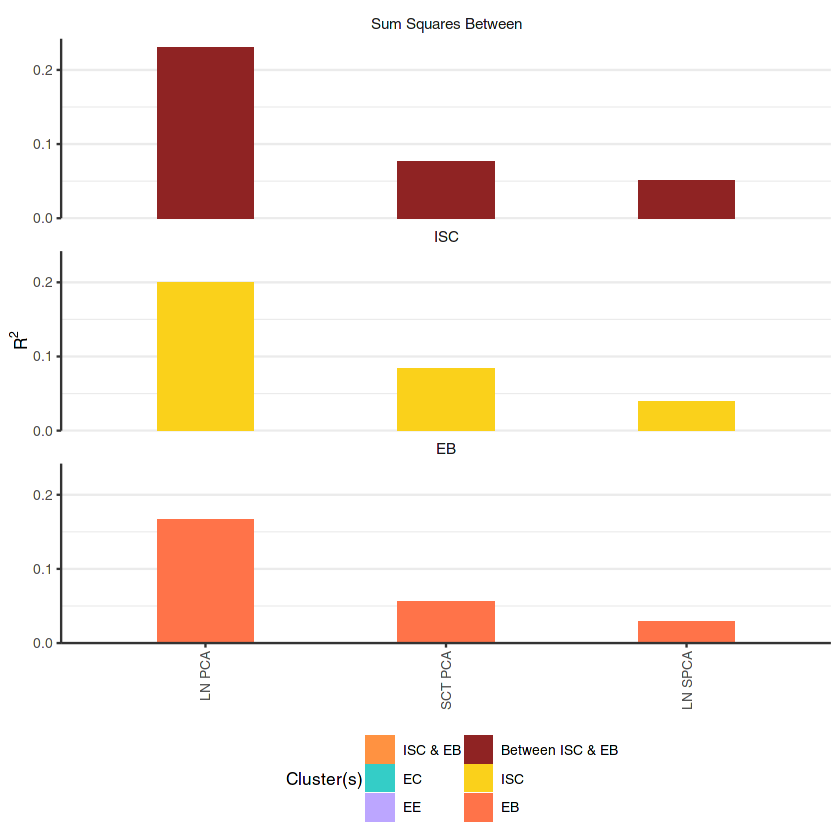

In [41]:
R2_bars

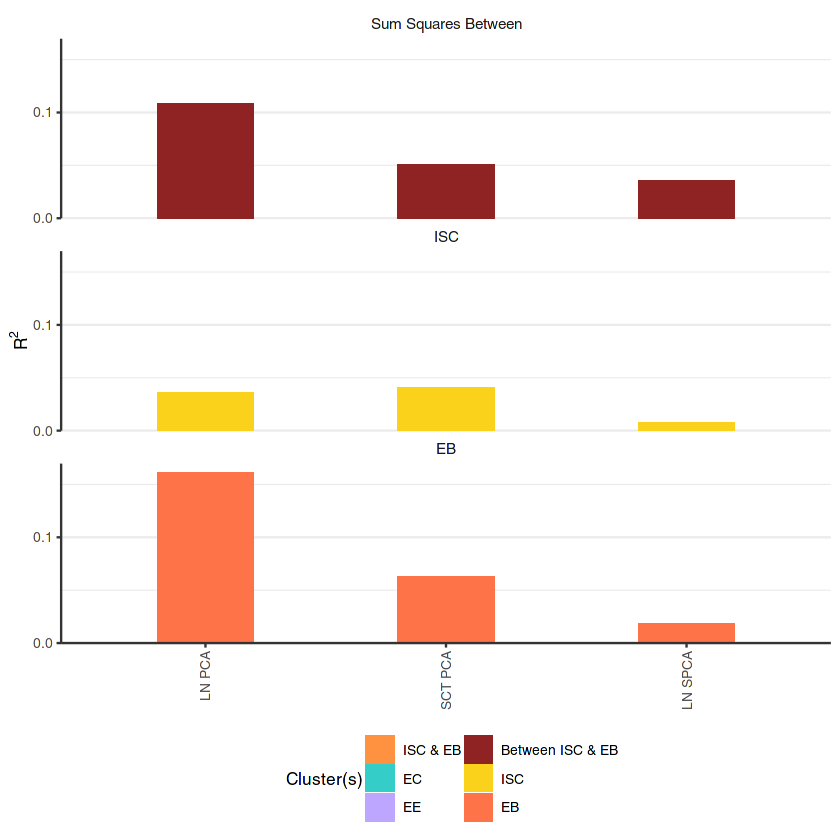

In [42]:
R2_bars %>%
        `$<-`(
          "data",
          value = mutate(.$data, R2 = pctMito_var / total_var)
        )

In [43]:
set.seed(0)
L <- cbind(
  set_panel_size(
    report_violin %>%
      `$<-`(
        "data",
        value = .$data %>%
          as.list() %>%
          replace(2, list(with(pcs, pctMito/total))) %>%
          as_tibble()
      ) %>%
      `+`(
        list(
          facet_wrap(~1)
        )
      ),
    w = unit(1.5, "in"),
    h = unit(1.5, "in")
  ),
  set_panel_size(
    report_bars %>%
      `$<-`(
        "data",
        mutate(
          .$data,
          var = cbind(
            Numer = pctMito_var,
            Total = total_var
          )[
            cbind(
              seq_along(facet),
              as.numeric(facet)
            )
          ],
          facet = facet %>% `levels<-`(levels(.) %>% replace(1, "% Mito"))
        )
      ) %>%
      `+`(
        list(
          theme(
            legend.position = "none"
          )
        )
      ),
    w = unit(c(0.5, 1), "in"),
    h = unit(1.5, "in")
  )
)
R <- set_panel_size(
      R2_bars %>%
        `$<-`(
          "data",
          value = mutate(.$data, R2 = pctMito_var / total_var)
        ) +
        theme(
          legend.position = "none"
        ),
      w = unit(1, "in"),
      h = unit(0.6, "in")
    )
ggsave(
  "figure/Fig4PctMito.pdf",
  gtable(
    unit.c(sum(L$widths), sum(R$widths)),
    unit.c(unit(1, "null"), sum(get_legend(R2_bars)$heights))
  ) %>%
    gtable_add_grob(
      list(L, R, get_legend(R2_bars + theme(legend.position = "bottom"))),
      l = c(1:2, 1),
      r = c(1:2, 2),
      t = c(1, 1, 2)
    ),
  w = 6,
  h = 5
)

Warning message:
“The following aesthetics were dropped during statistical transformation: weight
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?”


Warning message in x[i] <- value:
“number of items to replace is not a multiple of replacement length”


In [44]:
set.seed(0)
L <- cbind(
  set_panel_size(
    report_violin %>%
      `$<-`(
        "data",
        value = .$data %>%
          as.list() %>%
          replace(2, list(with(pcs, pctRibo/total))) %>%
          as_tibble()
      ) %>%
      `+`(
        list(
          facet_wrap(~1)
        )
      ),
    w = unit(1.5, "in"),
    h = unit(1.5, "in")
  ),
  set_panel_size(
    report_bars %>%
      `$<-`(
        "data",
        mutate(
          .$data,
          var = cbind(
            Numer = pctRibo_var,
            Total = total_var
          )[
            cbind(
              seq_along(facet),
              as.numeric(facet)
            )
          ],
          facet = facet %>% `levels<-`(levels(.) %>% replace(1, "% Ribo"))
        )
      ) %>%
      `+`(
        list(
          theme(
            legend.position = "none"
          )
        )
      ),
    w = unit(c(0.5, 1), "in"),
    h = unit(1.5, "in")
  )
)
R <- set_panel_size(
      R2_bars %>%
        `$<-`(
          "data",
          value = mutate(.$data, R2 = pctRibo_var / total_var)
        ) +
        theme(
          legend.position = "none"
        ),
      w = unit(1, "in"),
      h = unit(0.6, "in")
    )
ggsave(
  "figure/Fig4PctRibo.pdf",
  gtable(
    unit.c(sum(L$widths), sum(R$widths)),
    unit.c(unit(1, "null"), sum(get_legend(R2_bars)$heights))
  ) %>%
    gtable_add_grob(
      list(L, R, get_legend(R2_bars + theme(legend.position = "bottom"))),
      l = c(1:2, 1),
      r = c(1:2, 2),
      t = c(1, 1, 2)
    ),
  w = 6,
  h = 5
)

Warning message:
“The following aesthetics were dropped during statistical transformation: weight
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?”


Warning message in x[i] <- value:
“number of items to replace is not a multiple of replacement length”


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Warning message:
“The following aesthetics were dropped during statistical transformation: weight
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?”


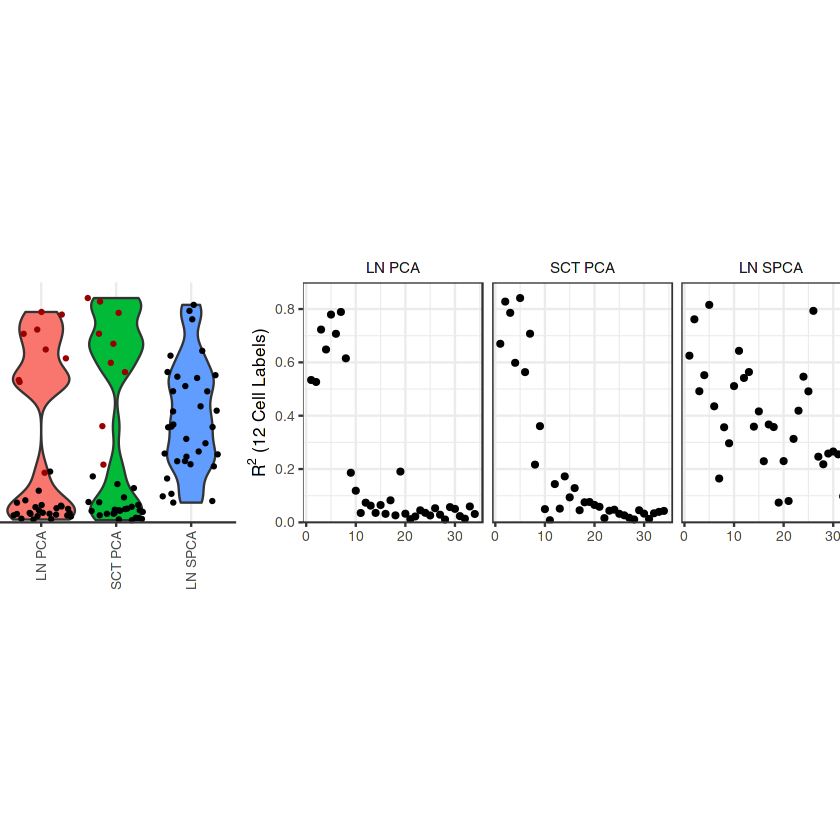

In [45]:
set.seed(0)
report <- cbind(
  (
    simple_violin_plot(with(pcs, tibble(reduction, explained/total, total)), bw=0.05, size=1.5) +
      scale_y_continuous(limits=c(0,0.9), expand=c(0,0), breaks=c(0,0.2,0.4,0.6,0.8)) +
      geom_blank(data = tibble(cluster = "LN PCA", embedding = 0.1, weight = 1, facet = "")) +
      facet_wrap(vars(facet)) +
      theme(
        legend.position = "none",
        strip.background = element_blank()
      )
  ) %>%
    set_panel_size(w = unit(2, "in"), h = unit(2, "in")),
  (
    ggplot(
      pcs,
      aes(dim, explained/total)
    ) +
      facet_wrap(vars(reduction)) +
      geom_point(stroke = NA, size = 2) +
      scale_y_continuous(limits=c(0,0.9), expand=c(0,0), breaks=c(0,0.2,0.4,0.6,0.8)) +
      labs(
        x = NULL,
        y = bquote(R^2*" (12 Cell Labels)")
      )
  ) %>%
    set_panel_size(w = unit(1.5, "in"), h = unit(2, "in"))
)
grid.draw(report)
ggsave("figure/Fig4ExplainedVariance.pdf", report, w=7.5, h=3)